In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from numpy.linalg import norm

from scipy.sparse import lil_matrix

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

# Load datasets

In [2]:
train_rating = pd.read_csv("../data/train_rating.csv")
test_pair = pd.read_csv("../data/test_pair.csv")

item_feat = pd.read_csv("../data/item_feats.csv")
user_feat = pd.read_csv("../data/user_feats.csv")

sub = pd.read_csv('../predict/sample_submission.csv')

# EDA

## Data Types
* UserId, ItemId : str
* rating : float 
* side information V1, V3 in item_feat are int -> Discrete Type RV
* side information V2 in item_feat is float -> Continuous Type RV
* side information V1 in user_feat is float -> Continuous Type RV
* side information V2, V3, V4 in user_feat are int -> Discrete Type RV

### test_pair

In [3]:
print('UserId data type: ' , type(test_pair['UserId'][0]) ) 
print('ItemId data type: ' , type(item_feat['ItemId'][0]) )
test_pair.head(3)

UserId data type:  <class 'str'>
ItemId data type:  <class 'str'>


,UserId,ItemId
0,DCC1A9,282298
1,895206,A9D3D8
2,C38E32,38D5EE


### item_feat

In [4]:
print('ItemId data type: ' , type(item_feat['ItemId'][0]) ) 
print('V1 data type: ' , type(item_feat['V1'][0]) )
print('V2 data type: ' , type(item_feat['V2'][0]) )
print('V3 data type: ' , type(item_feat['V3'][0]) )
item_feat.head(3)

ItemId data type:  <class 'str'>
V1 data type:  <class 'numpy.int64'>
V2 data type:  <class 'numpy.float64'>
V3 data type:  <class 'numpy.int64'>


,ItemId,V1,V2,V3
0,9AF5AA,8366,7.496452,2041
1,960857,10416,7.686800,1247
2,3FC7E9,1670,7.635397,1248


### train_rating

In [5]:
print('UserId data type: ' , type(train_rating['UserId'][0]) ) 
print('ItemId data type: ' , type(train_rating['ItemId'][0]) )
print('rating data type: ' , type(train_rating['rating'][0]) )
train_rating.head(3)

UserId data type:  <class 'str'>
ItemId data type:  <class 'str'>
rating data type:  <class 'numpy.float64'>


,UserId,ItemId,rating
0,A22818,70621F,0.0
1,36B488,16553B,0.0
2,AB1C55,035CDE,0.0


### user_feat

In [7]:
print('UserId data type: ' , type(user_feat['UserId'][0]) ) 
print('V1 data type: ' , type(user_feat['V1'][0]) )
print('V2 data type: ' , type(user_feat['V2'][0]) )
print('V3 data type: ' , type(user_feat['V3'][0]) )
print('V4 data type: ' , type(user_feat['V4'][0]) )
user_feat.head(3)

UserId data type:  <class 'str'>
V1 data type:  <class 'numpy.float64'>
V2 data type:  <class 'numpy.int64'>
V3 data type:  <class 'numpy.int64'>
V4 data type:  <class 'numpy.int64'>


,UserId,V1,V2,V3,V4
0,1CDE4D,NaN,5233,982,330
1,1FEE19,2.896804,6968,262,330
2,B14416,NaN,4787,1608,267


## No. of Users and Items 
* No. of Users = 5766
* No. of items = 20251

In [8]:
n_user = len(set(user_feat["UserId"]))
print("n_user in training =", n_user)
n_item = len(set(item_feat["ItemId"]))
print("n_item in training =", n_item)

n_user in training = 27000
n_item in training = 26000


## Check no. of users who didn't rate any item

In [9]:
no_rating_users = user_feat.set_index('UserId').index.difference(train_rating.set_index('UserId').index)
print("No. of no rating users:", len(no_rating_users) )

No. of no rating users: 21234


## Check no. of items which didn't recieve any rating

In [10]:
no_rating_items = item_feat.set_index('ItemId').index.difference(train_rating.set_index('ItemId').index)
print("No. of no rating items:", len(no_rating_items) )

No. of no rating items: 5749


## Correlation between variables and rating

### Correlation between user features variables and rating 
* User_mean_ratings are not linear correlated with uesr features 
* V1, V2, V3, V4 in user features are not really linear correlated
* V1 and V4 has the highest correlation but still around 0.1 

In [11]:
# get user mean rating
user_mean = train_rating[['UserId','rating']].groupby(['UserId']).mean()
# concat features and rationg
user_mean_rating = pd.concat([user_mean, user_feat.set_index('UserId')], axis =1)
user_mean_rating.corr()

,rating,V1,V2,V3,V4
rating,1.000000,0.006956,-0.008383,-0.024794,0.073029
V1,0.006956,1.000000,-0.001254,-0.010570,0.101653
V2,-0.008383,-0.001254,1.000000,0.060035,-0.044762
V3,-0.024794,-0.010570,0.060035,1.000000,-0.004453
V4,0.073029,0.101653,-0.044762,-0.004453,1.000000


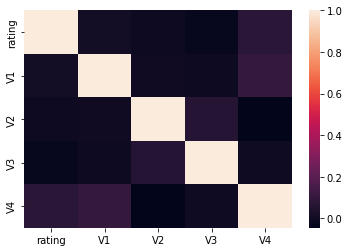

In [12]:
import seaborn as sns
ax = sns.heatmap(user_mean_rating.corr())

### item_feat side info variables
* Item_mean_ratings are not linear correlated with item features 
* V1, V2, V3 in item features are not linear correlated

In [13]:
# get item mean rating
item_mean = train_rating[['ItemId','rating']].groupby(['ItemId']).mean()
# concat features and rationg
item_mean_rating = pd.concat([item_mean, item_feat.set_index('ItemId')], axis =1)
item_mean_rating.corr()

,rating,V1,V2,V3
rating,1.000000,0.001805,0.004561,0.001998
V1,0.001805,1.000000,-0.007890,0.040643
V2,0.004561,-0.007890,1.000000,0.007543
V3,0.001998,0.040643,0.007543,1.000000


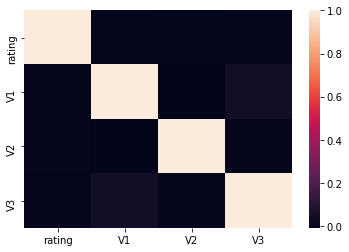

In [82]:
import seaborn as sns
ax = sns.heatmap(item_mean_rating.corr())

## Check na 

In [86]:
pd.isna(train_rating).sum()

UserId    0
ItemId    0
rating    0
dtype: int64

In [87]:
pd.isna(user_feat).sum()

UserId        0
V1        10573
V2            0
V3            0
V4            0
dtype: int64

In [88]:
pd.isna(item_feat).sum()

ItemId    0
V1        0
V2        0
V3        0
dtype: int64

## Check infinity
* No infinity in training rating
* 417 infinity in V2 of item features (1.6%)
* 47 infinity in V1 of user features (0.174%)

In [100]:
# for train_rating
import math
n_inf = 0
for i in range(len(train_rating)):
    if ( math.isinf(train_rating.iloc[i,2]) ):
        n_inf = n_inf + 1
print('No. of infinity in train_rating :', n_inf)

No. of infinity in train_rating : 0


In [99]:
# for item_feat
for j in range(len(item_feat.columns) -1 ):
    n_inf = 0
    for i in range(len(item_feat)):
        if ( math.isinf(item_feat.iloc[i,j+1]) ):
            n_inf = n_inf + 1
    print('In V'+str(j+1), ', no. of n_inf :', n_inf)

In V1 , no. of n_inf : 0
In V2 , no. of n_inf : 417
In V3 , no. of n_inf : 0


In [103]:
417 / len(item_feat)

0.01603846153846154

In [102]:
# for user_feat
for j in range(len(user_feat.columns) -1 ):
    n_inf = 0
    for i in range(len(user_feat)):
        if ( math.isinf(user_feat.iloc[i,j+1]) ):
            n_inf = n_inf + 1
    print('In V'+str(j+1), ', no. of n_inf :', n_inf)

In V1 , no. of n_inf : 47
In V2 , no. of n_inf : 0
In V3 , no. of n_inf : 0
In V4 , no. of n_inf : 0


In [104]:
47 / len(user_feat)

0.0017407407407407408

# Analsis on Rating

In [118]:
import warnings
warnings.filterwarnings("ignore")

### Rating

In [123]:
print( 'Max:', train_rating['rating'].max())
print( 'Min:', train_rating['rating'].min())

Max: 5.0
Min: 0.0


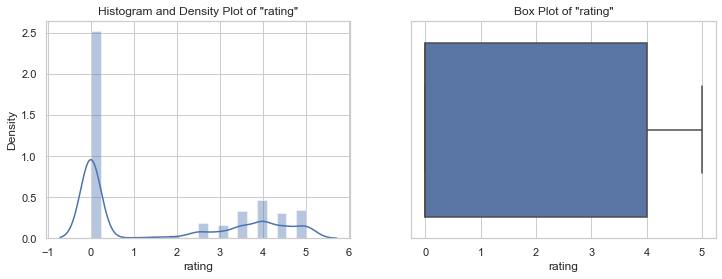

In [119]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(12,4) )
axes[0].set_title('Histogram and Density Plot of "rating"' )
axes[1].set_title('Box Plot of "rating"' )
sns.set_theme(style="whitegrid")
p = sns.distplot(train_rating['rating'],  hist=True, kde=True , ax=axes[0])
#p.set( xticks = np.arange(6+1))
box = sns.boxplot(x=train_rating['rating'] , ax=axes[1])

## User mean rating (many users give only 0 rating)

In [159]:
p = user_mean['rating'].value_counts()[0]
print( p, '('+str(  round(p /len(user_mean) * 100))+'%)', 'users only give 0 ratings')

1538 (27%) users only give 0 ratings


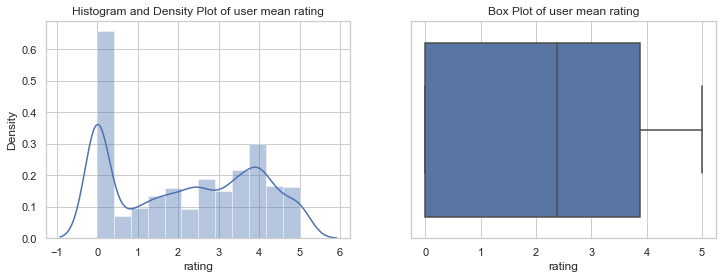

In [120]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(12,4) )
axes[0].set_title('Histogram and Density Plot of user mean rating' )
axes[1].set_title('Box Plot of user mean rating' )
sns.set_theme(style="whitegrid")
p = sns.distplot(user_mean['rating'],  hist=True, kde=True , ax=axes[0])
#p.set( xticks = np.arange(6+1))
box = sns.boxplot(x=user_mean['rating'] , ax=axes[1])

### Item mean rating (many items only recieve mean rating 0)

In [160]:
p = item_mean['rating'].value_counts()[0]
print( p, '('+str(  round(p /len(item_mean) * 100))+'%)', 'items are only rated 0')

9286 (46%) items are only rated 0


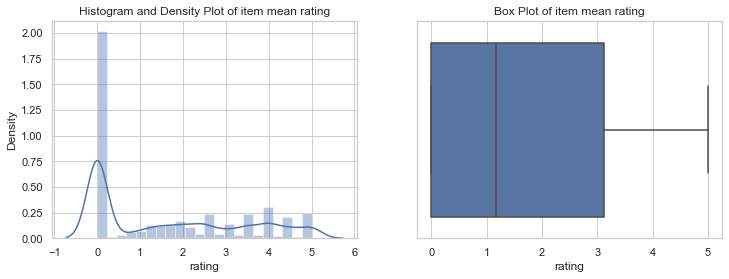

In [122]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(12,4) )
axes[0].set_title('Histogram and Density Plot of item mean rating' )
axes[1].set_title('Box Plot of item mean rating' )
sns.set_theme(style="whitegrid")
p = sns.distplot(item_mean['rating'],  hist=True, kde=True , ax=axes[0])
#p.set( xticks = np.arange(6+1))
box = sns.boxplot(x=item_mean['rating'] , ax=axes[1])

### No. of rating each item received (Many outliers, the no. of rating can be differ greatly from item to item)

In [142]:
a = train_rating[['ItemId','rating']].copy()
a['number'] = [1]*len(train_rating)
print( 'Max no. of rating in each item:', a.groupby(['ItemId']).sum()['number'].max())
print( 'Mean no. of rating in each item:', a.groupby(['ItemId']).sum()['number'].mean())
print( 'Min no. of rating in each item:', a.groupby(['ItemId']).sum()['number'].min())
print( 'sd of no. of rating in each item:', a.groupby(['ItemId']).sum()['number'].std())

Max no. of rating in each item: 138
Mean no. of rating in each item: 1.9910621697693942
Min no. of rating in each item: 1
sd of no. of rating in each item: 2.7869305408712486


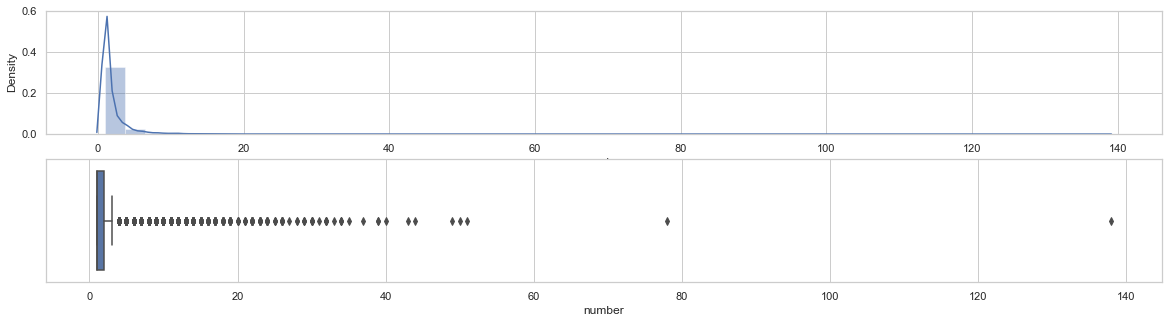

In [136]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 1, figsize=(20,5) )

p = sns.distplot(a.groupby(['ItemId']).sum()['number'],  hist=True, kde=True, ax=axes[0])
box = sns.boxplot(x = a.groupby(['ItemId']).sum()['number'] , ax=axes[1])

### No. of rating each user gave (Even more outliers, the no. of rating can be differ greatly from user to user)

In [140]:
b = train_rating[['UserId','rating']].copy()
b['number'] = [1]*len(train_rating)
print( 'Max no. of rating each user gave:', b.groupby(['UserId']).sum()['number'].max())
print( 'Mean no. of rating each user gave:', b.groupby(['UserId']).sum()['number'].mean())
print( 'Min no. of rating each user gave:', b.groupby(['UserId']).sum()['number'].min())
print( 'sd of no. of rating each user gave:', b.groupby(['UserId']).sum()['number'].std())

Max no. of rating each user gave: 2670
Mean no. of rating each user gave: 6.992889351370101
Min no. of rating each user gave: 1
sd of no. of rating each user gave: 47.5937723382835


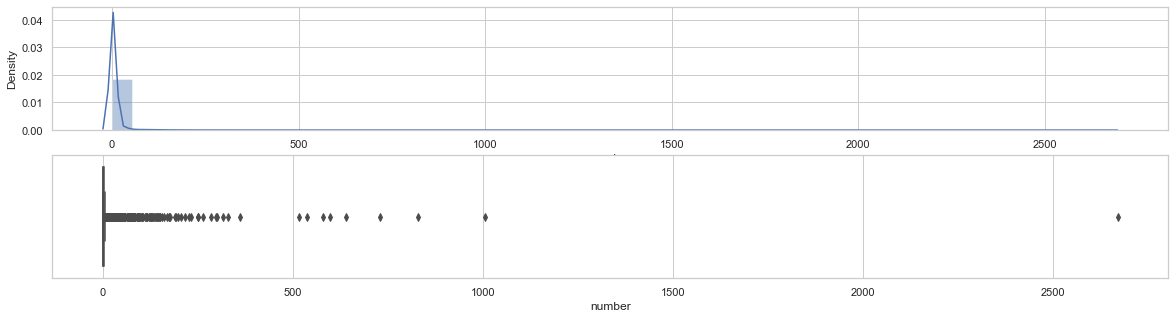

In [139]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 1, figsize=(20,5) )

p = sns.distplot(b.groupby(['UserId']).sum()['number'],  hist=True, kde=True, ax=axes[0])
box = sns.boxplot(x = b.groupby(['UserId']).sum()['number'] , ax=axes[1])

### no. of rating does not correlate with rating

In [149]:
pd.concat([user_mean,b.groupby(['UserId']).sum()['number']], axis =1) .corr()

,rating,number
rating,1.000000,-0.048639
number,-0.048639,1.000000


In [150]:
pd.concat([item_mean, a.groupby(['ItemId']).sum()['number']], axis =1).corr()

,rating,number
rating,1.000000,0.011179
number,0.011179,1.000000
